# Scaling with domain size 3

In [1]:
from jwave.geometry import Domain
from jax import numpy as jnp
from jwave.geometry import Medium,TimeAxis,_points_on_circle, Sensors, _sphere_mask
from jwave.acoustics import ongrid_wave_propagation
from timeit import timeit
from matplotlib import pyplot as plt

In [32]:
N0 = 256

In [33]:
N, dx = (N0, N0, N0), (0.1e-3, 0.1e-3, 0.1e-3)
domain = Domain(N, dx)
sound_speed = jnp.ones(N)*1500
medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=15)

sensors_positions = (jnp.array([25]), jnp.array([25]), jnp.array([25]))
sensors = Sensors(positions=sensors_positions)

mask1 = _sphere_mask(N, 8, (N0//2,N0//2,N0//2))
p0 = 5.*mask1

In [34]:
time_axis = TimeAxis.from_medium(medium, cfl=0.3, t_end=0.25*1.998e-5)

params, j_solver = ongrid_wave_propagation(
    medium=medium,
    time_array=time_axis,
    output_t_axis = time_axis,
    sensors=sensors,
    backprop=False,
    p0 = p0
)

In [35]:
time_axis.to_array().shape

(250,)

In [36]:
p = j_solver(params)

In [37]:
%timeit j_solver(params).block_until_ready()

10.7 s ± 8.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
steps = [48, 64, 96, 128, 192, 256]

# Times in ms
mean_times = [.083,   .153,  .608, 1.390, 4.69, 10.7]
std_times =  [.3e-3, .5e-3, .5e-3, .8e-3,  .02, .008]

In [39]:
!nvidia-smi

Thu Dec  2 20:01:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:01:00.0 Off |                  N/A |
| 65%   77C    P0    39W / 125W |   7436MiB /  7973MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

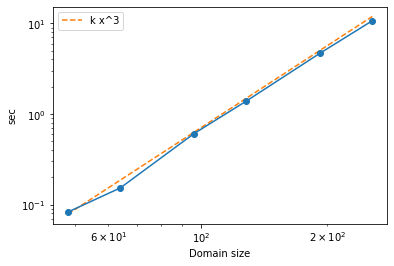

In [51]:
plt.errorbar(steps, mean_times, yerr=std_times, marker='o')
x_cube = list(map(lambda x: float(x/112)**3, steps))
plt.plot(steps, x_cube, linestyle='--', label="k x^3")

plt.ylabel("sec")
plt.xlabel("Domain size")
plt.xscale("log")
plt.yscale("log")
plt.legend()